#Imports

In [6]:
!pip install grad-cam

In [7]:
# Standard library
import os
import time
import random
from datetime import datetime

# Data handling
import requests
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

# PyTorch & vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import timm
import torchvision.transforms as transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from torch.amp import autocast, GradScaler
# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# Scikit-learn metrics & utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve,recall_score,
    f1_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    precision_recall_curve,
    confusion_matrix
)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
import numpy as np
from PIL import Image

def shades_of_gray(img: Image.Image, illuminant: str = "gray_world", p: float = 6.0) -> Image.Image:
    """
    Applies Shades-of-Gray color constancy to a PIL image.

    Args:
        img:      PIL.Image in RGB mode.
        illuminant: Only "gray_world" is supported here.
        p:        Minkowski norm power (commonly between 4 and 8).

    Returns:
        A new PIL.Image with color-corrected pixels.
    """
    assert img.mode == "RGB", "Image must be in RGB mode"
    # 1) Convert to float32 array, scale [0,1]
    arr = np.asarray(img).astype(np.float32) / 255.0

    # 2) Compute the Minkowski p‐norm per channel
    #    m_c = ( mean( channel^p ) )^(1/p)
    m = np.mean(arr**p, axis=(0,1))**(1.0/p)  # shape (3,)

    # 3) Compute scaling factors so that after correction the illuminant is gray
    #    scale = mean(m) / m_c
    mean_m = np.mean(m)
    scale = mean_m / m

    # 4) Apply scales
    arr_corrected = arr * scale[None,None,:]

    # 5) Clip back to [0,1], convert to uint8
    arr_corrected = np.clip(arr_corrected, 0.0, 1.0)
    img_out = Image.fromarray((arr_corrected * 255).astype(np.uint8), mode="RGB")
    return img_out


In [ ]:
os.makedirs("checkpoints", exist_ok=True)

In [ ]:
PATH_SCRIPT = "./prepare_data.py"
PATH_ZIP = "./"

In [ ]:
"""
# Uncomment this code and substitute the variables to run in colab
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# Substitute this variable (PATH_ZIP) with the folder with the zip files containing the images, downloaded from github
PATH_ZIP = "/content/drive/MyDrive/ZIPS_DATA"
# Substitute this variable (PATH_SCRIPT) with the file prepare_data.py
PATH_SCRIPT = "/content/drive/MyDrive/prepare_data.py" 
"""

In [9]:
!python "{PATH_SCRIPT}" --zip_dir "{PATH_ZIP}" --output_dir data_v1

Extracting images from ZIP files in: ./
Extracted 11730 images to 'ISIC_IMAGES'.
Fetching metadata from ISIC API...
Collected 11720 metadata entries.
Building dataframe from metadata and filtering by extracted images...
Train: 6117 patients, 8180 samples
  Benign 81.0% | Malignant 19.0%

Val: 1311 patients, 1694 samples
  Benign 82.8% | Malignant 17.2%

Test: 1311 patients, 1697 samples
  Benign 81.9% | Malignant 18.1%



# Dataset & Dataloaders

The dataset is imbalanced, with the majority of images representing benign (non-cancerous) skin lesions.

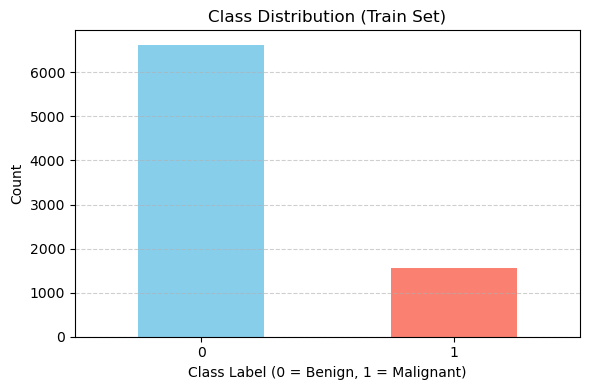

In [10]:
df = pd.read_csv("data_v1/lesions_train.csv")  # or lesions_val.csv, lesions.csv, etc.

plt.figure(figsize=(6, 4))
df['label'].value_counts().sort_index().plot(kind='bar', color=["skyblue", "salmon"])

plt.title("Class Distribution (Train Set)")
plt.xlabel("Class Label (0 = Benign, 1 = Malignant)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


This custom `SkinCancerDataset` class wraps our image DataFrame for PyTorch:

- **`dataframe`**: Pandas DataFrame containing `file`, `patient`, and `label` columns.  
- **`image_dir`**: Directory where the images (`<isic_id>.jpg`) are stored.  
- **`transform`**: A `torchvision.transforms.Compose` object for preprocessing and (optionally) augmentations.  
- **`return_filename`**: If `True`, `__getitem__` returns `(image, label, filename)`, useful for logging .

In [11]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, return_filename=False):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.return_filename = return_filename

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["file"])
        label = torch.tensor(row["label"], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.return_filename:
            return image, label, row["file"]
        else:
            return image, label

Augmentation and pre-processing

In [12]:
train_transform = transforms.Compose([
   # transforms.Lambda(lambda img: shades_of_gray(img, illuminant="gray_world", p=6.0)),
    transforms.RandomResizedCrop(224),   # or 300 for B3
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
   # transforms.Lambda(lambda img: shades_of_gray(img, illuminant="gray_world", p=6.0)),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

Wrap `SkinCancerDataset` in a PyTorch `DataLoader`

In [13]:
PATH = "/content/ISIC_IMAGES"

# Load CSVs generated by prepare_data.py
train_df = pd.read_csv("data_v1/lesions_train.csv")
val_df   = pd.read_csv("data_v1/lesions_val.csv")
test_df = pd.read_csv("data_v1/lesions_test.csv")

train_dataset = SkinCancerDataset(
    train_df,
    PATH,
    transform=train_transform,
    return_filename=False
)

# Compute weights for class-balanced sampling (60/40 ratio)
p_m = train_df["label"].mean()
w_benign    = 0.6 / (1.0 - p_m)
w_malignant = 0.4 / p_m

sample_weights = train_df["label"].map({
    0: w_benign,
    1: w_malignant
}).values

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_dataset = SkinCancerDataset(
    val_df,
    PATH,
    transform=val_transform,
    return_filename=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)


test_dataset = SkinCancerDataset(
    test_df,
    PATH,
    transform=val_transform,
    return_filename=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Model, Loss, Optimizer & Scheduler

Focal Binary Cross‐Entropy (Focal BCE) loss down‐weights easy examples and focuses training on hard, misclassified samples.







In [14]:
class FocalBCELoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=0.5, reduction="mean", use_focal=True):
        """
        alpha: weight for the positive (malignant) class (0 < alpha < 1)
               smaller alpha → less emphasis on positives
        gamma: focusing parameter (≥0), smaller → less focus on hard examples
        reduction: 'mean' or 'sum'
        use_focal: if False, falls back to plain BCEWithLogitsLoss
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.use_focal = use_focal

        if self.use_focal:
            # keep one BCE-with-logits loss per example for focal computation
            self.bce = nn.BCEWithLogitsLoss(reduction='none')
        else:
            # if not using focal, just use standard BCEWithLogitsLoss with reduction
            self.bce = nn.BCEWithLogitsLoss(reduction=self.reduction)

    def forward(self, logits, targets):
        # logits: raw model outputs (no sigmoid), shape [batch_size]
        # targets: ground-truth labels (0.0 or 1.0), shape [batch_size]

        if not self.use_focal:
            # simple binary cross-entropy on logits
            return self.bce(logits, targets)

        # 1. Compute per-example BCE loss (no reduction)
        bce_loss = self.bce(logits, targets)  # shape [batch_size]

        # 2. Convert logits to probabilities in [0,1]
        prob = torch.sigmoid(logits)          # shape [batch_size]

        # 3. p_t: model's probability of the true class
        #    for positive: prob; for negative: 1 - prob
        p_t = prob * targets + (1 - prob) * (1 - targets)

        # 4. alpha factor: alpha for positives, (1 - alpha) for negatives
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # 5. focal factor: (1 - p_t)^gamma — focuses on hard (uncertain) examples
        focal_factor = (1 - p_t) ** self.gamma

        # 6. Combine: alpha * focal * bce
        loss = alpha_factor * focal_factor * bce_loss  # shape [batch_size]

        # 7. Reduce to scalar
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss  # return per-example losses if reduction is None


**Training configuration:**  
- **Loss:** Focal Binary Cross‐Entropy.  
- **Optimizer:** AdamW (learning rate = 3e-4, weight decay = 1e-4).  
- **LR Scheduler:** Cosine annealing over 30 epochs (`T_max=30`).  


In [15]:
# — Hyper-parameters —
n_epochs      = 20
freeze_epochs = 3
lr_head       = 3e-4
lr_backbone   = 1e-4
weight_decay  = 1e-4
accum_steps   = 2  # 32 × 2 = effective batch 64

# — Model, loss, device —
model = timm.create_model(
    "efficientnet_b0",# For b3 - efficientnet_b3
    pretrained=True,
    num_classes=1
)
criterion = FocalBCELoss(gamma=2, alpha=0.6)
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# — 1) Freeze stem + block0 for warm-up —
for p in model.conv_stem.parameters():
    p.requires_grad = False
for p in model.blocks[0].parameters():
    p.requires_grad = False

# — 2) Build optimizer with two LR groups —
head_params     = list(model.classifier.parameters())
backbone_params = [p for n, p in model.named_parameters() if "classifier" not in n]

optimizer = AdamW(
    [
        {"params": head_params,     "lr": lr_head},
        {"params": backbone_params, "lr": lr_backbone}
    ],
    weight_decay=weight_decay
)

# — 3) AMP scaler & scheduler —
scaler    = GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

# — Reset GPU stats if on CUDA —
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)


C:\Users\pedro\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


# Training & Validation Helper Functions

In [16]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2



def apply_mixup_or_cutmix(x, y, alpha=0.2, mode=None):
    """
    Applies MixUp or CutMix to a batch of images and labels.

    Args:
        x (Tensor): batch of images (B, C, H, W)
        y (Tensor): batch of labels (B,)
        alpha (float): beta distribution parameter
        mode (str or None): 'mixup', 'cutmix', or None

    Returns:
        x_aug (Tensor): augmented images
        y_a (Tensor): original labels
        y_b (Tensor): shuffled labels
        lam (float): mix ratio
    """
    if mode is None:
        return x, y, y, 1.0  # no mixup/cutmix

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    y_a = y
    y_b = y[rand_index]
    x2 = x[rand_index]

    if mode == 'mixup':
        x = lam * x + (1 - lam) * x2
    elif mode == 'cutmix':
        bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
        x[:, :, bbx1:bbx2, bby1:bby2] = x2[:, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby1 - bby2) / (x.size(-1) * x.size(-2)))
    else:
        raise ValueError(f"Invalid mode: {mode}")

    return x, y_a, y_b, lam

def apply_random_mix(x, y, alpha=0.4, prob_mixup=0.5, prob_cutmix=0.3):
    """
    Randomly applies MixUp, CutMix, or nothing to the batch.
    """
    p = np.random.rand()
    if p < prob_mixup:
        return apply_mixup_or_cutmix(x, y, alpha, mode="mixup")
    elif p < prob_mixup + prob_cutmix:
        return apply_mixup_or_cutmix(x, y, alpha, mode="cutmix")
    else:
        return x, y, y, 1.0  # no mixing


In [17]:
def train_one_epoch(loader, model, criterion, optimizer, scaler, device, accum_steps, use_mixup=False):
    model.train()
    running_loss = 0.0
    logits_all, probs_all, labels_all = [], [], []

    optimizer.zero_grad()
    pbar = tqdm(loader, desc="  [Train]   ", leave=False)
    for i, (X, y) in enumerate(pbar):
        X, y = X.to(device), y.to(device)

        with autocast(device_type="cuda"):
            if use_mixup:
                X_m, y_a, y_b, lam = apply_mixup_or_cutmix(X, y, mode="mixup")
                logits = model(X_m).squeeze()
                raw_loss = lam * criterion(logits, y_a.float()) + (1 - lam) * criterion(logits, y_b.float())
            else:
                logits = model(X).squeeze()
                raw_loss = criterion(logits, y.float())

            loss = raw_loss / accum_steps

        scaler.scale(loss).backward()

        if (i + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        batch_size = X.size(0)
        running_loss += raw_loss.item() * batch_size
        logits_all.extend(logits.detach().cpu().numpy())
        probs_all.extend(torch.sigmoid(logits).detach().cpu().numpy())
        labels_all.extend(y.cpu().numpy())

        pbar.set_postfix({
            "loss": f"{raw_loss.item():.3f}",
            "lr": optimizer.param_groups[0]['lr']
        })

    if len(loader) % accum_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    avg_loss = running_loss / len(loader.dataset)
    train_auroc = roc_auc_score(labels_all, probs_all)
    return avg_loss, logits_all, probs_all, labels_all, train_auroc

def validate_one_epoch(loader):
    model.eval()
    logits_all, labels_all, files_all = [], [], []

    with torch.no_grad():
        for X, y, fn in tqdm(loader, desc="  [Validate]", leave=False):
            X = X.to(device)
            logits = model(X).squeeze()
            logits_all.extend(logits.cpu().numpy())
            labels_all.extend(y.numpy())
            files_all.extend(fn)

    y_true = np.array(labels_all)
    y_prob = torch.sigmoid(torch.tensor(logits_all)).cpu().numpy()
    val_loss = criterion(
        torch.tensor(logits_all),
        torch.tensor(labels_all)
    ).item()
    auroc    = roc_auc_score(y_true, y_prob)

    return val_loss, auroc, y_true, y_prob, files_all


#Main Training Loop

**Note about early stop**: In imbalanced medical datasets, loss can decrease even when model performance on the minority class (malignant) degrades. This leads to misleadingly optimistic results. AUROC, on the other hand, evaluates the model's ability to separate the two classes regardless of class imbalance or threshold, making it a more reliable early stopping criterion in this context.

In [ ]:

# — Metric & timing trackers —
epoch_times       = []
train_losses      = []
train_aurocs      = []
val_losses        = []
val_aurocs        = []
all_epoch_true    = []
all_epoch_prob    = []
all_epoch_files   = []
best_val_auroc    = 0.0
best_epoch        = 1

print("Starting training...\n")

for epoch in range(1, n_epochs + 1):
    # — Unfreeze at start of epoch 4 —
    if epoch == freeze_epochs + 1:
        print(">>> Unfreezing stem + block0 now")
        for p in model.conv_stem.parameters():
            p.requires_grad = True
        for p in model.blocks[0].parameters():
            p.requires_grad = True
        # no need to rebuild optimizer; param-groups are already set

    start = time.time()
    print(f"--- Epoch {epoch}/{n_epochs} ---")

    # === Train (with AMP & grad-acc inside train_one_epoch) ===
    train_loss, logits, probs, labels, train_auroc = train_one_epoch(
        train_loader,
        model,
        criterion,
        optimizer,
        scaler,
        device,
        accum_steps,
    )
    train_losses.append(train_loss)
    train_aurocs.append(train_auroc)

    # === Validate ===
    val_loss, val_auroc, y_true, y_prob, val_files = validate_one_epoch(val_loader)
    val_losses.append(val_loss)
    val_aurocs.append(val_auroc)

    # === Store raw predictions for thresholding later ===
    all_epoch_true.append(y_true)
    all_epoch_prob.append(y_prob)
    all_epoch_files.append(val_files)

    # === Print summary ===
    print(f"Train Loss: {train_loss:.4f} | Train AUROC: {train_auroc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   AUROC: {val_auroc:.4f}\n")

    # === Scheduler step ===
    scheduler.step()

    # === Timing ===
    elapsed = time.time() - start
    epoch_times.append(elapsed)
    print(f"Epoch Time: {elapsed:.1f} sec\n")

    # === Save best model ===
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        best_epoch     = epoch
        torch.save(model.state_dict(), "checkpoints/best_model.pt")

print(f"Best AUROC {best_val_auroc:.4f} at epoch {best_epoch}")


Starting training...

--- Epoch 1/20 ---


  [Train]   :   0%|                                                                            | 0/256 [00:00<?, ?it/s]C:\Users\pedro\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


#Learning Curves & Helper functions and Metric analysis

In [ ]:
history = pd.DataFrame({
    "epoch":       list(range(1, n_epochs+1)),
    "train_loss":  train_losses,
    "train_auroc": train_aurocs,
    "val_loss":    val_losses,
    "val_auroc":   val_aurocs,
})



In [ ]:
best_auroc_epoch   = history["val_auroc"].idxmax() + 1
print(f"Best AUROC:   {history.val_auroc.max():.4f} at epoch {best_auroc_epoch}")
best_epoch = best_auroc_epoch


**Loss vs. Epoch**

In [ ]:
plt.figure()
plt.figure()
plt.plot(history.epoch, history.train_loss, label="Train Loss")
plt.plot(history.epoch, history.val_loss,   label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Loss Curves")
plt.show()


**AUROC vs. Epoch**

In [ ]:
plt.figure()
plt.plot(history.epoch, history.val_auroc,    label="Val   AUROC")
plt.plot(history.epoch, history.train_auroc,    label="Train   AUROC")
plt.xlabel("Epoch"); plt.ylabel("Metric")
plt.legend(); plt.title("Val Metrics Over Epochs")
plt.show()


##Threshold Analysis on Final Epoch

In [ ]:
def get_epoch_preds(epoch_idx, threshold=0.5):
    """
    Returns (filenames, y_true, y_prob, y_pred) for epoch `epoch_idx` (0-based),
    where y_pred is computed by thresholding y_prob.
    """
    files  = all_epoch_files[epoch_idx]
    y_true = np.array(all_epoch_true[epoch_idx])
    y_prob = np.array(all_epoch_prob[epoch_idx])
    y_pred = (y_prob >= threshold).astype(int)
    return files, y_true, y_prob, y_pred

**ROC Curve with Youden Poin**

In [ ]:
files, y_true, y_prob,_= get_epoch_preds(best_epoch - 1)

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
J = tpr - fpr
idx = J.argmax()
youden_thresh = thresholds[idx]

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUROC={history.val_auroc.max():.3f})")
plt.scatter(fpr[idx], tpr[idx], color="red", label=f"Youden={youden_thresh:.2f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.title("ROC Curve with Youden Point")
plt.show()


**Precision-Recall Curve**

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, y_prob)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

**Confusion Matrices at Both Thresholds**

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, (thr, title) in zip(axes, [(0.5, "Thresh=0.5"), (youden_thresh, f"Youden={youden_thresh:.2f}")]):
    cm = confusion_matrix(y_true, (y_prob >= thr).astype(
      int))
    sns.heatmap(cm, annot=True, fmt="d", ax=ax,
                xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.suptitle("Confusion Matrices")
plt.show()


##Validation Classification Reports

In [ ]:
from sklearn.metrics import f1_score

auroc_at_x = history.val_auroc.iloc[best_epoch - 1]
print(f"AUROC at epoch {best_epoch} = {auroc_at_x:.4f}")

for thr in [0.5, youden_thresh]:
    print(f"--- Classification Report @ threshold = {thr:.2f} ---")
    y_pred_thr = (y_prob >= thr).astype(int)
    print(classification_report(y_true, y_pred_thr, target_names=["Benign","Malignant"]))

    balacc = balanced_accuracy_score(y_true, y_pred_thr)
    macro_f1 = f1_score(y_true, y_pred_thr, average="macro")

    print(f"Balanced Accuracy: {balacc:.3f}")
    print(f"Macro F1 Score:    {macro_f1:.3f}")


In [ ]:
plt.plot(epoch_times, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Epoch Duration")
plt.grid(True)
plt.show()

In [ ]:
def print_correct_diagnoses(epoch_idx, thresholds=[0.50, 0.37]):
    for thresh in thresholds:
        print(f"\n--- Threshold = {thresh:.2f} ---")
        _, y_true, _, y_pred = get_epoch_preds(epoch_idx, threshold=thresh)

        total_malignant = (y_true == 1).sum()
        total_benign    = (y_true == 0).sum()

        correct_malignant = ((y_true == 1) & (y_pred == 1)).sum()
        correct_benign    = ((y_true == 0) & (y_pred == 0)).sum()

        pct_malignant = 100 * correct_malignant / total_malignant
        pct_benign    = 100 * correct_benign    / total_benign

        print(f"Correct cancer diagnoses:     {correct_malignant}/{total_malignant} = {pct_malignant:.2f}%")
        print(f"Correct non-cancer diagnoses: {correct_benign}/{total_benign} = {pct_benign:.2f}%")

print_correct_diagnoses(epoch_idx=best_epoch-1, thresholds=[0.50, youden_thresh])


#Test the model

## Helper Functions

In [ ]:
def compute_auroc_ci(y_true, y_prob, n_bootstraps=1000, seed=42):
    """
    Computes AUROC with a 95% confidence interval using bootstrapping.

    Parameters:
        y_true (array-like): Ground truth binary labels (0 or 1)
        y_prob (array-like): Predicted probabilities
        n_bootstraps (int): Number of bootstrap iterations
        seed (int): Random seed for reproducibility

    Returns:
        auroc (float), ci_lower (float), ci_upper (float)
    """

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    auroc = roc_auc_score(y_true, y_prob)

    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = rng.choice(len(y_true), size=len(y_true), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_prob[indices])
        bootstrapped_scores.append(score)

    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)

    return auroc, ci_lower, ci_upper


##Test the model

In [ ]:
THRESHOLD = youden_thresh

In [ ]:
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=1
)

model.load_state_dict(torch.load("checkpoints/best_model.pt"))
model.to(device)


In [ ]:
# 1) Initialize Python lists
y_true = []
y_prob = []

model.eval()
with torch.no_grad():
    for inputs, labels, _ in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 2) Forward + sigmoid in one shot, keep as CPU list
        outputs = model(inputs).squeeze(-1)        # [B]
        probs = torch.sigmoid(outputs).cpu().tolist()

        # 3) Extend your lists directly
        y_prob.extend(probs)
        y_true.extend(labels.cpu().tolist())

# 4) Now convert to NumPy (for metrics) if you need:
import numpy as np
y_true = np.array(y_true)
y_prob = np.array(y_prob)

In [ ]:
# 1) AUROC + CI
test_auroc, ci_lower, ci_upper = compute_auroc_ci(y_true, y_prob)
print(f"AUROC = {test_auroc:.3f} (95% CI: {ci_lower:.3f} – {ci_upper:.3f})")

# 2) Find threshold for 95% specificity
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
specificity = 1 - fpr
# pick the highest threshold that still gives specificity >= 0.95
idx = np.where(specificity >= 0.95)[0]
if len(idx) == 0:
    tau95 = 0.5  # fallback
else:
    tau95 = thresholds[idx[-1]]
print(f"Threshold for 95% specificity: {tau95:.3f}")

# 3) Binarize at that threshold
test_y_pred95 = (y_prob >= tau95).astype(int)

# 4) Other metrics at τ95
test_recall95 = recall_score(y_true, test_y_pred95)
test_bal_acc  = balanced_accuracy_score(y_true, test_y_pred95)
test_macro_f1 = f1_score(y_true, test_y_pred95, average="macro")

print(f"Recall @ 95% Spec:           {test_recall95:.3f}")
print(f"Balanced Accuracy @ τ95:    {test_bal_acc:.3f}")
print(f"Macro F1 Score @ τ95:       {test_macro_f1:.3f}")